# BERT-Klassifikation der Heise-Newsticker-Meldungen

Kontakt: christian.winkler@datanizing.com

Es lohnt sich durchaus, andere Modelle von https://huggingface.co/models auszuprobierenwie z.B. `dbmdz/bert-base-german-uncased` von der Bayerischen Staatsbibliothek.

Angelehnt an https://mccormickml.com/2019/07/22/BERT-fine-tuning/

# Torch-Konfiguration

In [1]:
import torch

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print("Using GPU %s" % torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU :-(")

Using GPU NVIDIA GeForce RTX 4090


# Daten einlesen

In [ ]:
!test -f newsticker-2022-2023-good-bad.csv.gz || wget https://github.com/datanizing/m3-llm-workshop/raw/main/newsticker-2022-2023-good-bad.csv.gz

In [2]:
import pandas as pd

df = pd.read_csv("newsticker-2022-2023-good-bad.csv.gz", index_col="id")

In [3]:
df

,headline,comments,time,quality
id,,,,
6233916,Zentrum für KI in der Medizin ​soll für modern...,1.0,2023-11-16 09:20:00.000000,bad
6266836,Bericht: Höchststand bei Anschlägen auf Geldau...,132.0,2022-12-03 17:17:00.000000,good
6287308,Werkstattberichte: Neues aus den Fablabs und d...,2.0,2022-01-18 10:07:00.000000,bad
6315231,Apple wünscht sich mehr Bluetooth-Bandbreite,109.0,2022-01-03 13:38:00.000000,good
6315548,HoloLens Summit: virtuelle Konferenz für Anwen...,1.0,2022-01-01 12:05:00.000000,bad
...,...,...,...,...
9584239,Neue Förderrichtlinie: Bundesregierung drängt ...,557.0,2023-12-31 10:20:00.000000,good
9584333,37C3: Übertreibt es nicht mit der Softwareisie...,98.0,2023-12-31 11:33:00.000000,good
9584447,EU-Vorschlag: Selbstverpflichtung statt Cookie...,100.0,2023-12-31 15:35:00.000000,good


In [4]:
# Labels auf Integer wandeln
df["label"] = 0
df.loc[df["quality"] == "good", "label"] = 1
df.head()

,headline,comments,time,quality,label
id,,,,,
6233916,Zentrum für KI in der Medizin ​soll für modern...,1.0,2023-11-16 09:20:00.000000,bad,0
6266836,Bericht: Höchststand bei Anschlägen auf Geldau...,132.0,2022-12-03 17:17:00.000000,good,1
6287308,Werkstattberichte: Neues aus den Fablabs und d...,2.0,2022-01-18 10:07:00.000000,bad,0
6315231,Apple wünscht sich mehr Bluetooth-Bandbreite,109.0,2022-01-03 13:38:00.000000,good,1
6315548,HoloLens Summit: virtuelle Konferenz für Anwen...,1.0,2022-01-01 12:05:00.000000,bad,0


In [5]:
# in Arrays wandeln
text = df["headline"].values
labels = df["label"].values

# Tokenisierung

In [ ]:
!pip install transformers

In [6]:
from transformers import BertTokenizer

model_name = "dbmdz/bert-base-german-uncased"
# model_name = "bert-base-multilingual-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)

In [7]:
# Bestimmung der Maximallänge der Sätze, um Platz zu sparen
max_len = max([len(tokenizer.encode(t, add_special_tokens=True)) for t in text])
max_len

34

In [8]:
# Jetzt alle Sätze tokenisieren und IDs merken
input_ids = []
attention_masks = []

for t in text:
    encoded_dict = tokenizer.encode_plus(
                        t,
                        add_special_tokens = True,    # '[CLS]' und '[SEP]'
                        max_length = 64,
                        truncation = True,
                        pad_to_max_length = True,
                        return_attention_mask = True,  # Attention-Masks erzeugen
                        return_tensors = 'pt',         # pytorch-Tensoren als Ergebnis
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Python-Listen in Tensoren wandeln
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Headline, Tokenisierung und IDs anzeigen
print(text[0])
print(tokenizer.tokenize(text[0]))
print(input_ids[0])

/home/cwinkler/.venv/jupyter/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Zentrum für KI in der Medizin ​soll für moderne Gesundheitsversorgung sorgen
['zentrum', 'fur', 'ki', 'in', 'der', 'medizin', 'soll', 'fur', 'moderne', 'gesundheits', '##versorgung', 'sorgen']
tensor([  102,  3935,  9586, 12281,   142,   127,  3739,   556,  9586,  6727,
         4376,  6385,  4096,   103,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


# Daten aufteilen

In [9]:
from torch.utils.data import TensorDataset, random_split

# Wir arbeiten ab jetzt nur noch mit dem Input-Tensor, der Attention Mask und den Labeln
dataset = TensorDataset(input_ids, attention_masks, labels)

# wir nutzen einen 3:1-Split für Training und Validierung
train_size = int(0.75 * len(dataset))
val_size = len(dataset) - train_size
# reproduzierbar arbeiten!
torch.manual_seed(42)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(train_size, val_size)

9979 3327


In [10]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# die BERT-Autoren empfehlen für Finetuning Batch-Sizes von 16 oder 32
batch_size = 32

# DataLoader fÃ¼r die beiden Datensets erzeugen (man könnte auch RandomSampler verwenden)
train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = batch_size)
validation_dataloader = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset), batch_size = batch_size)

# Modell laden

In [11]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# das Modell muss zum Tokenizer passen!
model = BertForSequenceClassification.from_pretrained(
    model_name, 
    num_labels = 2, # wir haben nur gut oder shlecht
    output_attentions = False,
    output_hidden_states = False # wir benÃ¶tigen keine Embeddings
)
# hier evtl. model.cpu() einsetzen
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-german-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31102, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [12]:
# Optimierer auswählen, AdamW ist Standard
optimizer = AdamW(model.parameters(), lr = 2e-5)

/home/cwinkler/.venv/jupyter/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [13]:
from transformers import get_linear_schedule_with_warmup

# vier Epochen, das kann justiert werden
epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [14]:
import numpy as np

# Accuracy berechnen
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [15]:
import random
import numpy as np
from tqdm.auto import trange, tqdm

# alle Zufallszahlengeneratoren initialisieren (Reproduzierbarkeit)
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Statistik fÃ¼r das Training
training_stats = []

for epoch_i in trange(epochs, desc="Epoche"):
    # akkumulierter Loss für diese Epoche
    total_train_loss = 0

    # Modell in Trainingsmodus stellen
    model.train()

    # Trainig pro Batch
    for step, batch in enumerate(tqdm(train_dataloader, desc="Training")):
        # Daten entpacken und in device-Format wandeln
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Gradienten löschen
        model.zero_grad()        

        # Vorwärts-Auswertung (Trainingsdaten vorhersagen)
        res = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Loss berechnen und akkumulieren
        total_train_loss += res.loss.item()

        # Rückwärts-Auswertung, um Gradienten zu bestimmen
        res.loss.backward()

        # Gradient beschrÃ¤nken wegen Exploding Gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Parameter und Lernrate aktualisieren
        optimizer.step()
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
      

    # Modell in Vorhersage-Modus umstellen
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Eine Epoche validieren
    for batch in tqdm(validation_dataloader, desc="Validierung"):
        # jetzt die Validierungs-Daten entpacken
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Rückwärts-Auswertung wird nicht benötigt, daher auch kein Gradient
        with torch.no_grad():        
            # Vorhersage durchfÃ¼hren
            res = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Loss akkumulieren
        total_eval_loss += res.loss.item()

        # Vorhersagedaten in CPU-Format wandeln, um Accuracy berechnen zu können
        logits = res.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Accuracy für die Verifikation
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    tqdm.write("Accuracy: %f" % avg_val_accuracy)

    # Loss über alle Batches
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    tqdm.write("Validation loss %f" % avg_val_loss)

    # Statistik speichern für Auswertung
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Validierung Loss': avg_val_loss,
            'Accuracy': avg_val_accuracy
        }
    )

Epoche:   0%|          | 0/4 [00:00<?, ?it/s]

Training:   0%|          | 0/312 [00:00<?, ?it/s]

Validierung:   0%|          | 0/104 [00:00<?, ?it/s]

Accuracy: 0.800151
Validation loss 0.426460


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Validierung:   0%|          | 0/104 [00:00<?, ?it/s]

Accuracy: 0.813082
Validation loss 0.436112


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Validierung:   0%|          | 0/104 [00:00<?, ?it/s]

Accuracy: 0.817880
Validation loss 0.460262


Training:   0%|          | 0/312 [00:00<?, ?it/s]

Validierung:   0%|          | 0/104 [00:00<?, ?it/s]

Accuracy: 0.822687
Validation loss 0.512036


In [16]:
import pandas as pd

df_stats = pd.DataFrame(data=training_stats).set_index("epoch")
df_stats

,Training Loss,Validierung Loss,Accuracy
epoch,,,
1,0.527641,0.426460,0.800151
2,0.355522,0.436112,0.813082
3,0.240282,0.460262,0.817880
4,0.160003,0.512036,0.822687


<AxesSubplot:xlabel='epoch'>

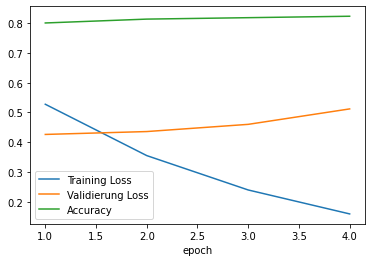

In [17]:
df_stats.plot()